# HDBSCAN should work well on embedding representations

In [1]:
import os
import re
import json
import hdbscan

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from collections import Counter
import matplotlib.pyplot as plt

import lib.helper as helper
import lib.embedding_models as reps

from importlib import reload

%matplotlib inline

## 1.  Retrieve Corpus

The corpus is being scraped by the "run_news_scrapes.py" script (and windows task scheduler) every 12 hours, a bit past midday and a bit past midnight.

The "bing" corpus are news titles and text extracts gotten from the bing news search API, using a few Home Office - related keywords.

The "RSS" corpus is plugged directly into a number of RSS feeds for world news sites and local british news sites, with no filters for news story types or subjects applied.

In [2]:
# Should be same path for all my PC's, it's where each scrape goes as a separate json file.
storage_path = "D:/Dropbox/news_crow/scrape_results"

# "bing" is targeted news search corpus, "RSS" is from specific world and local news feeds.
corpus_type = "RSS"

# Load up
corpus = helper.load_clean_world_corpus(storage_path, corpus_type)

# Make sure after cleaning etc it's indexed from 0
corpus.reset_index(inplace=True)
corpus.index.name = "node"

# See how it turned out
print(corpus.shape)
corpus.head()

Total files: 495
9.9 percent of files read.
19.8 percent of files read.
29.7 percent of files read.
39.6 percent of files read.
49.5 percent of files read.
59.4 percent of files read.
69.3 percent of files read.
79.2 percent of files read.
89.1 percent of files read.
99.0 percent of files read.
(31393, 9)


,index,title,summary,date,link,source_url,retrieval_timestamp,origin,clean_text
node,,,,,,,,,
0,0,Hurricane Dorian lashes US as Bahamas counts cost,"Life-threatening US storm surges are feared, a...","Thu, 05 Sep 2019 16:03:44 GMT",https://www.bbc.co.uk/news/world-us-canada-495...,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Hurricane Dorian lashes US as Bahamas counts c...
1,1,Kohistan video murders: Three guilty in 'honou...,They are relatives of a group of Pakistani wom...,"Thu, 05 Sep 2019 13:53:17 GMT",https://www.bbc.co.uk/news/world-asia-49592540,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Kohistan video murders: Three guilty in 'honou...
2,2,MH17 Ukraine plane crash: 'Key witness' released,A Ukrainian court releases a potentially key w...,"Thu, 05 Sep 2019 13:46:06 GMT",https://www.bbc.co.uk/news/world-europe-49591148,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,MH17 Ukraine plane crash: 'Key witness' releas...
3,3,Article 370: The weddings 'ruined' by Kashmir'...,Indian-administered Kashmir is under a securit...,"Thu, 05 Sep 2019 07:32:34 GMT",https://www.bbc.co.uk/news/world-asia-india-49...,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Article 70: The weddings 'ruined' by Kashmir's...
4,4,Syria war: Turkey warns Europe of new migrant ...,President Erdogan demands international help t...,"Thu, 05 Sep 2019 16:11:48 GMT",https://www.bbc.co.uk/news/world-europe-49599297,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Syria war: Turkey warns Europe of new migrant ...


## 2.  Build Text Model (Representation, eg; word2vec, entities list...)

- Trying with the world corpus and with the bing corpus, neither worked with InferSent.  Suspect the problem lies in the PCA step, which may not be working well on this high-dimensional (vector length = 4096) form.
- Summed keywords works rather better with the world corpus.
- Summed keywords still fail the bing/home office corpus, giving me a cluster about "immigration" and a cluster for the American Supreme Court.

## 2a.  Try a really simple averaged word vector model!

With a complex noun extraction function 'cause that part's slow so I multi-threaded it.

In [3]:
from gensim.models import Word2Vec
import spacy
nlp = spacy.load('en_core_web_sm')
from gensim.models.phrases import Phrases, Phraser

# Set vector size
vec_size = 100

In [4]:
def get_phrased_nouns(sentences):
    """ Use spacy to get all of the actual entities, conjoin bigram nouns. """

    # Get the lists of nouns
    noun_lists = []
    for doc in sentences:
        parsed = nlp(doc)
        noun_lists.append([token.lemma_ for token in parsed if token.pos_ == 'PROPN'])

    # Build the phrase model
    phrases = Phrases(noun_lists, min_count=5, threshold=0.5)

    # Get the set of phrases present in the model
    results = []
    for nouns in noun_lists:
        results.append(phrases[nouns])

    return results

# Get phrase-conjoined, lemmatized tokens
test = get_phrased_nouns(corpus['clean_text'])

# Detect and conjoin bigrams
model = Word2Vec(test, size=vec_size, window=5, min_count=1, workers=10)

In [5]:
def get_averaged_vec(token_list, model):
    
    vecs = []
    for token in token_list:
        try:
            vector = model.wv[token]
        except: 
            vector = np.zeros(vec_size)
        vecs.append(vector)
    
    if len(vecs) > 0:
        return np.mean(np.asarray(vecs), axis=0)
    else:
        return np.zeros(vec_size)

In [6]:
vectors = [get_averaged_vec(tokens, model) for tokens in test]

## 3. Cluster Text

This is the part where the pipelines get a little more experimental
- First; PCA (HDBSCAN prefers < 50 dimensions if possible) (also, try just fitting 50 vectors!)
- Second; HDBSCAN clustering

In [7]:
embeddings_array = np.vstack(vectors)

# First, PCA the data
pca = PCA(n_components=20, svd_solver='full')

# Fit and check
embeddings_pca = pca.fit_transform(embeddings_array)

# Diagnostic stats - both should show exponential decay
print(pca.explained_variance_ratio_)
print(pca.singular_values_) 

[9.95290852e-01 1.82153307e-03 1.58182423e-03 4.24818995e-04
 2.11819437e-04 1.37985434e-04 5.65983218e-05 3.57240403e-05
 2.36666670e-05 1.83944719e-05 1.69555066e-05 1.38116637e-05
 1.36340982e-05 1.29195679e-05 1.15302894e-05 1.00687755e-05
 9.74367843e-06 8.99641644e-06 8.85766446e-06 8.47946837e-06]
[170.29372016   7.28521137   6.788952     3.51824104   2.48431426
   2.00511945   1.28417853   1.02024368   0.83040925   0.73209474
   0.70287648   0.63437582   0.6302848    0.61354669   0.57962049
   0.54164153   0.53282562   0.51198637   0.50802284   0.497059  ]


In [8]:
# Clusterer fitting
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=10)
clusterer.fit(embeddings_pca)

# Diagnostic - calculate percentage of records assigned "outlier"
print("Percent outlier: ", 100.0 * sum(clusterer.labels_ == -1) / clusterer.labels_.shape[0])

# number of clusters created
print("Number of clusters: ", len(pd.unique(clusterer.labels_)))

# Record cluster each was assigned to
corpus['cluster'] = clusterer.labels_

# Record the reverse of outlier score (therefore, higher number = higher certainty of membership)
corpus['score'] = 1.0 - clusterer.outlier_scores_

corpus.to_csv("working/RSS_clustered_w2v_pca.csv", index=False)

Percent outlier:  67.10413149428217
Number of clusters:  231


C:\ProgramData\Anaconda3\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)


In [9]:
# For calculating silhouette score, a gauge of how well separated clusters
# are in some spatial representation
from sklearn.metrics import silhouette_score

# Filter out the outliers
embeddings_score = embeddings_pca[clusterer.labels_ != -1]
labels_score = clusterer.labels_[clusterer.labels_ != -1]

score = silhouette_score(embeddings_score, labels_score, metric="cosine")
score

-0.026391619835036642

In [10]:
Counter(clusterer.labels_)

Counter({-1: 21066,
         220: 1009,
         185: 15,
         224: 4607,
         60: 12,
         117: 22,
         86: 148,
         2: 120,
         35: 25,
         66: 28,
         214: 180,
         13: 32,
         136: 15,
         15: 56,
         55: 14,
         72: 32,
         83: 16,
         4: 68,
         19: 21,
         14: 59,
         135: 46,
         34: 9,
         178: 12,
         101: 31,
         133: 31,
         75: 19,
         32: 11,
         8: 6,
         54: 7,
         29: 15,
         67: 15,
         167: 16,
         11: 16,
         6: 15,
         77: 22,
         212: 12,
         1: 6,
         10: 8,
         129: 20,
         142: 17,
         166: 13,
         207: 6,
         126: 7,
         25: 11,
         211: 60,
         130: 25,
         176: 10,
         81: 5,
         70: 16,
         45: 25,
         175: 6,
         105: 11,
         48: 35,
         27: 8,
         170: 6,
         41: 15,
         61: 11,
         12: 1

c_v: 0.5222
c_npmi: 0.0477
Average document word count: 39.30283821234033
Number of documents: 31393
Latest record: Fri, 01 May 2020 00:18:25 GMT
Earliest record: Wed, 9 Oct 2019 21:52:38 +0000
Number of clusters: 231
Median cluster size: 11.0
Clustered docs: 32.9%

Best Performant (C_v)!
22696    I want to stay alive but I also want to stay a...
21293    Coronavirus cradle Wuhan partly reopens after ...
20665    It will kill a lot of people: Brazils overcrow...
31064    Risk has not been averted: Angela Merkel issue...
Name: clean_text, dtype: object
25334    Defectors drop leaflets and cash in North Kore...
24956    Kim Jong-un is alive but cannot stand up on hi...
24879    Video claiming Kim Jong-un dropped dead on off...
24855    I cant tell you: Trump adds to Kim Jong-un con...
Name: clean_text, dtype: object
23009    Deadly tornadoes batter southern US states. Of...
25601    US coronavirus deaths projection doubles - pre...
31094    US airlines and airports forced to create thei.

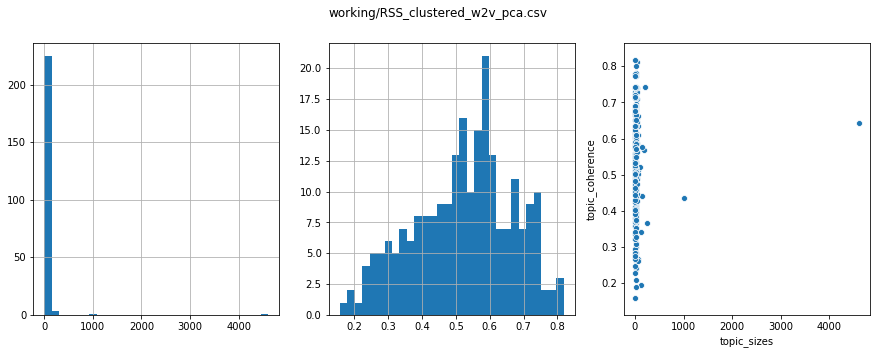

In [11]:
from imporlib import reload
reload(helper)
coherences = helper.report_corpus_model_coherence("working/RSS_clustered_w2v_pca.csv")

## 4. Cluster text with Spectral Clustering
Not working on high-dimensional data

## 5. Cluster text with Kmeans

Percent outlier:  0.0
Number of clusters:  200
c_v: 0.5227
c_npmi: 0.0311
Average document word count: 39.30283821234033
Number of documents: 31393
Latest record: Fri, 01 May 2020 00:18:25 GMT
Earliest record: Wed, 9 Oct 2019 21:52:38 +0000
Number of clusters: 191
Median cluster size: 80.0
Clustered docs: 99.9%

Best Performant (C_v)!
27939    Fury in Spain as Nissan keeps Sunderland plant...
19848    Spain's King Felipe VI renounces father's inhe...
8877     Who is Marie Yovanovitch? What to expect from ...
2132     Alicante floods leave terrified Brit family wi...
Name: clean_text, dtype: object
18831    Ronaldinho arrested in Paraguay over fake pass...
17783    Newborn baby is already fed up as she frowns a...
9974     Is Jeffrey Epstein’s ‘unholy alliance’ with th...
2790     Facebook suspends tens of thousands of apps. T...
Name: clean_text, dtype: object
24590    Climate crisis: Norway accused of acting like ...
26572    Michael Flynn: Judge suggests he may hold form...
8439     

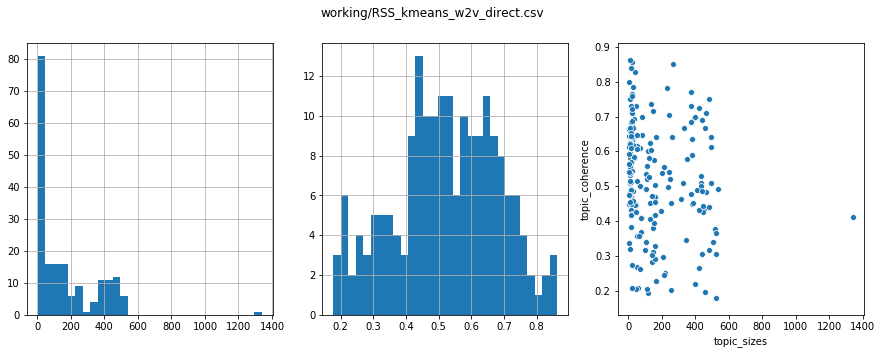

In [12]:
#from nltk.cluster.kmeans import KMeansClusterer
from sklearn.cluster import KMeans

#kmc = KMeansClusterer(num_means=60, distance=cosine_similarity)
#clusters = kmc.cluster(embeddings_array, True, trace=True)
#clusters

kmeans = KMeans(n_clusters=200, random_state=0).fit(embeddings_array)

# Diagnostic - calculate percentage of records assigned "outlier"
print("Percent outlier: ", 100.0 * sum(kmeans.labels_ == -1) / kmeans.labels_.shape[0])

# number of clusters created
print("Number of clusters: ", len(pd.unique(kmeans.labels_)))

# Record cluster each was assigned to
corpus['cluster'] = kmeans.labels_

# Record the reverse of outlier score (therefore, higher number = higher certainty of membership)
corpus['score'] = 1.0

# If cluster is smaller than minimum limit, designate as outlier
cs_lookup = corpus['cluster'].value_counts().to_dict()
corpus['cluster'] = corpus['cluster'].apply(lambda x: -1 if (cs_lookup[x] < 5) else x)

corpus.to_csv("working/RSS_kmeans_w2v_direct.csv", index=False)

coherences = helper.report_corpus_model_coherence("working/RSS_kmeans_w2v_direct.csv")

Percent outlier:  0.0
Number of clusters:  200
c_v: 0.5073
c_npmi: 0.027
Average document word count: 39.30283821234033
Number of documents: 31393
Latest record: Fri, 01 May 2020 00:18:25 GMT
Earliest record: Wed, 9 Oct 2019 21:52:38 +0000
Number of clusters: 191
Median cluster size: 81.0
Clustered docs: 99.9%

Best Performant (C_v)!
10917    New Zealand volcano: Two British women among i...
25585    New Zealand PM: No open borders for 'a long ti...
31313    Coronavirus is growing: Jacinda Ardern rejects...
11899    New Zealand is destroying military-style guns ...
Name: clean_text, dtype: object
22889    Coronavirus: US officials knew of Wuhan health...
1236     Trump is in severe mental decline: Concerns ra...
28957    Hillary Clinton questions how anybody with a b...
17613    This is shameful: Trump lambasted for coronavi...
Name: clean_text, dtype: object
28456    George Floyd death: More large protests in US ...
8048     Woman held 'smuggling gold in her shoes' on Ru...
28619    H

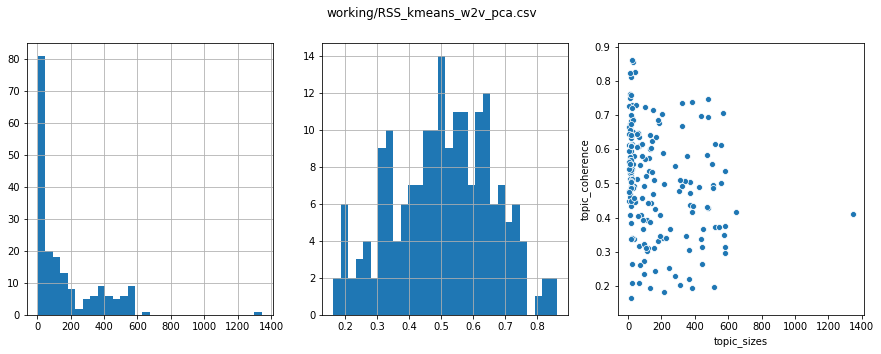

In [13]:
#from nltk.cluster.kmeans import KMeansClusterer
from sklearn.cluster import KMeans

#kmc = KMeansClusterer(num_means=60, distance=cosine_similarity)
#clusters = kmc.cluster(embeddings_array, True, trace=True)
#clusters

kmeans = KMeans(n_clusters=200, random_state=0).fit(embeddings_pca)

# Diagnostic - calculate percentage of records assigned "outlier"
print("Percent outlier: ", 100.0 * sum(kmeans.labels_ == -1) / kmeans.labels_.shape[0])

# number of clusters created
print("Number of clusters: ", len(pd.unique(kmeans.labels_)))

# Record cluster each was assigned to
corpus['cluster'] = kmeans.labels_

# Record the reverse of outlier score (therefore, higher number = higher certainty of membership)
corpus['score'] = 1.0

# If cluster is smaller than minimum limit, designate as outlier
cs_lookup = corpus['cluster'].value_counts().to_dict()
corpus['cluster'] = corpus['cluster'].apply(lambda x: -1 if (cs_lookup[x] < 5) else x)

corpus.to_csv("working/RSS_kmeans_w2v_pca.csv", index=False)

coherences = helper.report_corpus_model_coherence("working/RSS_kmeans_w2v_pca.csv")